In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
from io import BytesIO
import math
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Process Datasets - Children

## 1. Create Data Frame

In [2]:
#Read file
data = arff.loadarff('Autism-Child-Data.arff')
df_child = pd.DataFrame(data[0])
df_child

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',...,b'm',b'Others',b'no',b'no',b'Jordan',b'no',5.0,b'4-11 years',b'Parent',b'NO'
1,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',...,b'm',b'Middle Eastern ',b'no',b'no',b'Jordan',b'no',5.0,b'4-11 years',b'Parent',b'NO'
2,b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'1',b'0',b'0',...,b'm',b'?',b'no',b'no',b'Jordan',b'yes',5.0,b'4-11 years',b'?',b'NO'
3,b'0',b'1',b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',...,b'f',b'?',b'yes',b'no',b'Jordan',b'no',4.0,b'4-11 years',b'?',b'NO'
4,b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',...,b'm',b'Others',b'yes',b'no',b'United States',b'no',10.0,b'4-11 years',b'Parent',b'YES'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',...,b'f',b'White-European',b'yes',b'yes',b'United Kingdom',b'no',10.0,b'4-11 years',b'Parent',b'YES'
288,b'1',b'0',b'0',b'0',b'1',b'0',b'1',b'0',b'0',b'1',...,b'f',b'White-European',b'yes',b'yes',b'Australia',b'no',4.0,b'4-11 years',b'Parent',b'NO'
289,b'1',b'0',b'1',b'1',b'1',b'1',b'1',b'0',b'0',b'1',...,b'm',b'Latino',b'no',b'no',b'Brazil',b'no',7.0,b'4-11 years',b'Parent',b'YES'
290,b'1',b'1',b'1',b'0',b'1',b'1',b'1',b'1',b'1',b'1',...,b'm',b'South Asian',b'no',b'no',b'India',b'no',9.0,b'4-11 years',b'Parent',b'YES'


In [3]:
#check data type of each feature in the dataset
df_child.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         292 non-null    object 
 1   A2_Score         292 non-null    object 
 2   A3_Score         292 non-null    object 
 3   A4_Score         292 non-null    object 
 4   A5_Score         292 non-null    object 
 5   A6_Score         292 non-null    object 
 6   A7_Score         292 non-null    object 
 7   A8_Score         292 non-null    object 
 8   A9_Score         292 non-null    object 
 9   A10_Score        292 non-null    object 
 10  age              288 non-null    float64
 11  gender           292 non-null    object 
 12  ethnicity        292 non-null    object 
 13  jundice          292 non-null    object 
 14  austim           292 non-null    object 
 15  contry_of_res    292 non-null    object 
 16  used_app_before  292 non-null    object 
 17  result          

## 2. Decode Bytes Object

In [4]:
for key in df_child.columns.tolist():
    if(type(df_child[key][0]) == bytes):
        df_child[key] = df_child[key].str.decode('utf-8')
        
df_child.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,...,m,Others,no,no,Jordan,no,5.0,4-11 years,Parent,NO
1,1,1,0,0,1,1,0,1,0,0,...,m,Middle Eastern,no,no,Jordan,no,5.0,4-11 years,Parent,NO
2,1,1,0,0,0,1,1,1,0,0,...,m,?,no,no,Jordan,yes,5.0,4-11 years,?,NO
3,0,1,0,0,1,1,0,0,0,1,...,f,?,yes,no,Jordan,no,4.0,4-11 years,?,NO
4,1,1,1,1,1,1,1,1,1,1,...,m,Others,yes,no,United States,no,10.0,4-11 years,Parent,YES


## 3. Visualization

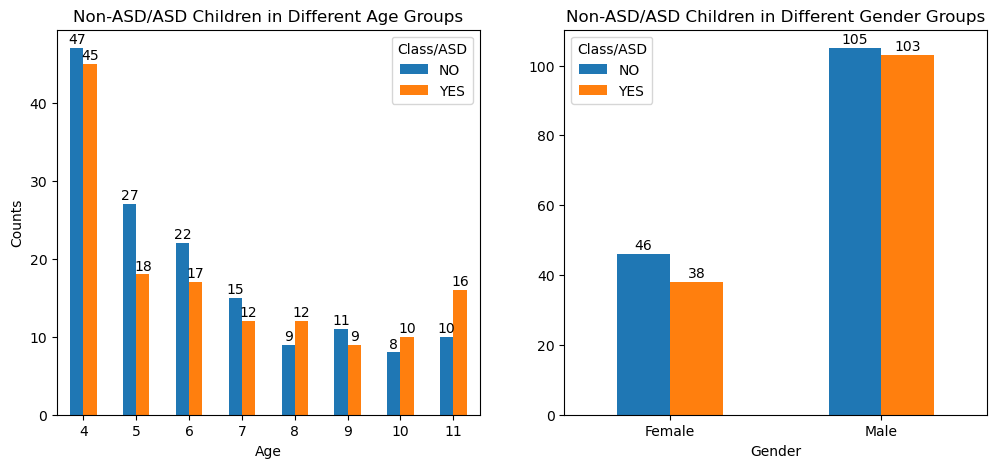

In [5]:
CrosstabResult_age = pd.crosstab(index = df_child['age'],columns = df_child['Class/ASD'], rownames=['Age'])
CrosstabResult_gender = pd.crosstab(index = df_child['gender'],columns = df_child['Class/ASD'], rownames=['Gender'])

fig, ax =plt.subplots(1, 2, figsize = (12,5))

#display the number of Non-ASD/ASD children in different age groups
CrosstabResult_age.plot.bar(ax = ax[0])
plt.sca(ax[0])
ax[0].set_title("Non-ASD/ASD Children in Different Age Groups")
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Counts')
plt.xticks(ticks=[0,1,2,3,4,5,6,7], labels=[4,5,6,7,8,9,10,11], rotation=0)

for bar in ax[0].patches:
    y_value = bar.get_height()
    x_value = bar.get_x() + bar.get_width() / 2
    space = 1
    label = format(y_value)
    ax[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
    
#display the number of Non-ASD/ASD children in different gender groups  
CrosstabResult_gender.plot.bar(ax = ax[1])
plt.sca(ax[1])
ax[1].set_title("Non-ASD/ASD Children in Different Gender Groups")
ax[1].set_xlabel('Gender')
plt.xticks(ticks=[0,1], labels=['Female','Male'], rotation = 0)

for bar in ax[1].patches:
    y_value = bar.get_height()
    x_value = bar.get_x() + bar.get_width() / 2
    space = 1
    label = format(y_value)
    ax[1].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')





## 4. Drop Unrelated Features

In [6]:
#drop 3 unrelated feature columns
df_child = df_child.drop(['ethnicity','contry_of_res', 'age_desc'], axis=1)

#check if features are dropped correctly
df_child

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,6.0,m,no,no,no,5.0,Parent,NO
1,1,1,0,0,1,1,0,1,0,0,6.0,m,no,no,no,5.0,Parent,NO
2,1,1,0,0,0,1,1,1,0,0,6.0,m,no,no,yes,5.0,?,NO
3,0,1,0,0,1,1,0,0,0,1,5.0,f,yes,no,no,4.0,?,NO
4,1,1,1,1,1,1,1,1,1,1,5.0,m,yes,no,no,10.0,Parent,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,1,1,1,1,1,1,1,1,1,1,7.0,f,yes,yes,no,10.0,Parent,YES
288,1,0,0,0,1,0,1,0,0,1,7.0,f,yes,yes,no,4.0,Parent,NO
289,1,0,1,1,1,1,1,0,0,1,4.0,m,no,no,no,7.0,Parent,YES
290,1,1,1,0,1,1,1,1,1,1,4.0,m,no,no,no,9.0,Parent,YES


## 5. One-Hot-Encoding
#### Convert not numeric data to numeric for analysis purpose

In [7]:
#check the different values each feature column has
for key in df_child.columns.tolist():
    unique_value = df_child[key].unique()
    print(key + " has value: ", unique_value )

A1_Score has value:  ['1' '0']
A2_Score has value:  ['1' '0']
A3_Score has value:  ['0' '1']
A4_Score has value:  ['0' '1']
A5_Score has value:  ['1' '0']
A6_Score has value:  ['1' '0']
A7_Score has value:  ['0' '1']
A8_Score has value:  ['1' '0']
A9_Score has value:  ['0' '1']
A10_Score has value:  ['0' '1']
age has value:  [ 6.  5.  4. 11. 10.  8.  7.  9. nan]
gender has value:  ['m' 'f']
jundice has value:  ['no' 'yes']
austim has value:  ['no' 'yes']
used_app_before has value:  ['no' 'yes']
result has value:  [ 5.  4. 10.  7.  8.  3.  9.  2.  1.  6.  0.]
relation has value:  ['Parent' '?' 'Self' 'Relative' 'Health care professional' 'self']
Class/ASD has value:  ['NO' 'YES']


In [8]:
#do ont-hot encoding
df_child['gender'] = df_child['gender'].map({'m': 0, 'f': 1})
df_child['jundice'] = df_child['jundice'].map({'no': 0, 'yes': 1})
df_child['austim'] = df_child['austim'].map({'no': 0, 'yes': 1})
df_child['used_app_before'] = df_child['used_app_before'].map({'no': 0, 'yes': 1})
df_child['relation'] = df_child['relation'].map({'Parent': 0, 'Self': 1, 'self': 1, 'Relative': 2, 'Health care professional': 3})
df_child['Class/ASD'] = df_child['Class/ASD'].map({'NO': 0, 'YES': 1})
df_child.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,5.0,0.0,0
1,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,5.0,0.0,0
2,1,1,0,0,0,1,1,1,0,0,6.0,0,0,0,1,5.0,NaN,0
3,0,1,0,0,1,1,0,0,0,1,5.0,1,1,0,0,4.0,NaN,0
4,1,1,1,1,1,1,1,1,1,1,5.0,0,1,0,0,10.0,0.0,1


## 6. Handle Missing Value

In [9]:
#print out samples that have missing values
df_child[df_child.isna().sum(axis=1) > 0]

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
2,1,1,0,0,0,1,1,1,0,0,6.0,0,0,0,1,5.0,NaN,0
3,0,1,0,0,1,1,0,0,0,1,5.0,1,1,0,0,4.0,NaN,0
5,0,0,1,0,1,1,0,1,0,1,4.0,0,0,1,0,5.0,NaN,0
9,0,0,1,1,1,0,1,1,0,0,11.0,1,0,1,0,5.0,NaN,0
11,0,1,0,0,1,0,0,0,0,1,5.0,1,0,0,0,3.0,NaN,0
19,1,1,1,1,1,1,0,1,0,1,5.0,0,0,0,0,8.0,NaN,1
21,0,0,1,1,0,1,0,1,1,0,9.0,1,0,0,0,5.0,NaN,0
24,1,0,1,1,1,1,0,1,1,1,11.0,0,0,0,0,8.0,NaN,1
28,0,1,1,0,0,0,1,1,0,1,6.0,0,0,1,0,5.0,NaN,0
32,1,0,0,1,0,1,1,1,1,1,NaN,0,0,0,0,7.0,NaN,1


In [10]:
#fill missing value of 'relation' with 'Parents', since most questions are answered by children's Parents
df_child['relation'].fillna(value = 0, inplace=True)

#fill missing value of 'age' with its mean
df_child['age'].fillna(round(df_child['age'].mean()), inplace=True)

In [11]:
#check if all missing values are handeled
df_child[df_child.isna().sum(axis=1) > 0]

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD


In [12]:
#convert all feature type to int
for key in df_child.columns.tolist():
    if(type(df_child[key][0]) != int):
        df_child[key] = df_child[key].astype(int)

#check the datatype after converting
df_child.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   A1_Score         292 non-null    int64
 1   A2_Score         292 non-null    int64
 2   A3_Score         292 non-null    int64
 3   A4_Score         292 non-null    int64
 4   A5_Score         292 non-null    int64
 5   A6_Score         292 non-null    int64
 6   A7_Score         292 non-null    int64
 7   A8_Score         292 non-null    int64
 8   A9_Score         292 non-null    int64
 9   A10_Score        292 non-null    int64
 10  age              292 non-null    int64
 11  gender           292 non-null    int64
 12  jundice          292 non-null    int64
 13  austim           292 non-null    int64
 14  used_app_before  292 non-null    int64
 15  result           292 non-null    int64
 16  relation         292 non-null    int64
 17  Class/ASD        292 non-null    int64
dtypes: int64(1

## 7. Check the Size and Balance of Processed Dataset 

In [13]:
#check if the size of processed dataset matches the size of original dataset(after dropping 3 feature columns)
print("Number of Non_ASD samples: ", len(df_child[df_child['Class/ASD'] == 0]))
print("Number of ASD samples: ", len(df_child[df_child['Class/ASD'] == 1]))

Number of Non_ASD samples:  151
Number of ASD samples:  141


# Build Random Forest Model

## 1. Split df_child into train and test sets

In [14]:
X = df_child.iloc[:, :-1] #feature columns
y = df_child.iloc[:,-1] #lable column

In [15]:
#split original dataset into test and taing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## 2. Train the model

In [16]:
#buit RF model, choose 500 as the number of estimator
model = RandomForestClassifier(n_estimators = 500)

In [17]:
#train RF model with training set
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

# Evaluate RF Model

## 1. Accuracy

In [18]:
#Get prediction result based on test set
y_pred = model.predict(X_test)

In [19]:
#find accuracy of model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


### Since the accuracy is 100%, we use shuffled version of  test label to calculate the accuracy again to make sure the model is trained correctly

In [20]:
import random

#shuffle the test label
y_shuffle = y_test.copy().tolist()
random.shuffle(y_shuffle)

print("Accuracy of shuffled:", accuracy_score(y_shuffle, y_pred))

Accuracy of shuffled: 0.3559322033898305


## 2. F1 Score

In [21]:
#find f1 score of model
f1 = f1_score(y_test, y_pred)
print('F1 Score: ', f1)

F1 Score:  1.0


## 3. Confusion Matrix

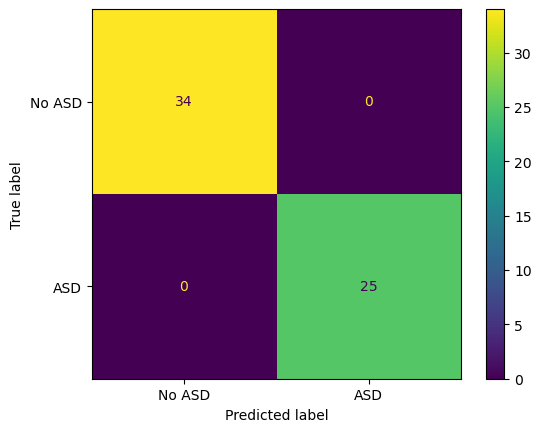

In [22]:
#plot confusion matrix of model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No ASD', 'ASD'])
disp.plot()
plt.show()

## 4. Feature Ranking

In [23]:
#get the index of descending sorted features
index = np.argsort(model.feature_importances_).tolist()
#reverse to ascending order
index.reverse
#display feature score
feature = [(X_train.columns[idx], model.feature_importances_[idx]) for idx in index]
feature 

[('used_app_before', 0.0012218202405095628),
 ('austim', 0.0030394958130752123),
 ('gender', 0.0035247574325109766),
 ('jundice', 0.004011462337798559),
 ('relation', 0.00527012652470545),
 ('A2_Score', 0.00935519233028955),
 ('age', 0.01489606177991259),
 ('A7_Score', 0.020149584348495914),
 ('A6_Score', 0.02434665406151057),
 ('A1_Score', 0.03207491854295933),
 ('A3_Score', 0.03334406809194072),
 ('A8_Score', 0.03555892169259403),
 ('A5_Score', 0.04127682028112784),
 ('A10_Score', 0.04266844586261157),
 ('A9_Score', 0.051168607954574986),
 ('A4_Score', 0.1227436325032028),
 ('result', 0.5553494302021804)]

Text(0, 0.5, 'Feature Name')

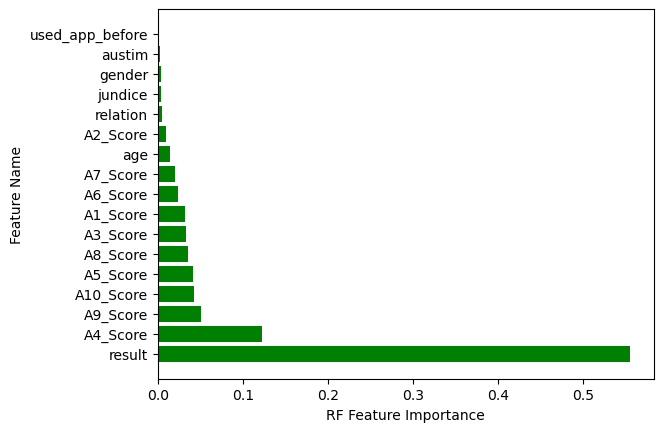

In [24]:
#plot bar chart of sorted features
plt.barh(X_train.columns[index], model.feature_importances_[index], color=['green'])
plt.gca().invert_yaxis()
plt.xlabel("RF Feature Importance")
plt.ylabel("Feature Name")

# Train Models with Limited Features

## 1. Use only "result" to predict

In [25]:
#only keep the feature of result
X_train_result = X_train['result'].values.reshape(-1,1)
X_test_result = X_test['result'].values.reshape(-1,1)

model_result = RandomForestClassifier(n_estimators = 500)
model_result.fit(X_train_result,y_train)

y_pred_result = model_result.predict(X_test_result)

print("Used features: ['result']")
print("Accuracy:", accuracy_score(y_test, y_pred_result))

Used features: ['result']
Accuracy: 1.0


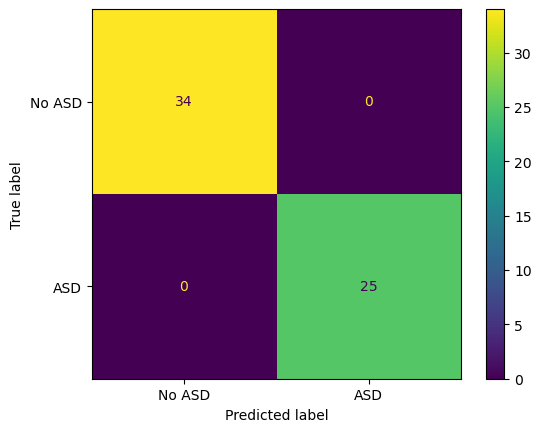

In [26]:
#plot confusion matrix
cm_result = confusion_matrix(y_test, y_pred_result)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_result, display_labels = ['No ASD', 'ASD'])
disp.plot()
plt.show()

## 2. Use the 10 questions A1 to A10 to predict

In [27]:
#only keep the features of A1 to A10 questions
X_train_10Q = X_train.drop(['used_app_before','age','gender','jundice','austim','result','relation'], axis=1)
X_test_10Q = X_test.drop(['used_app_before','age','gender','jundice','austim','result','relation'], axis=1)

model_10Q = RandomForestClassifier(n_estimators = 500)
model_10Q.fit(X_train_10Q,y_train)

y_pred_10Q = model_10Q.predict(X_test_10Q)

print("Used features:", X_train_10Q.columns.tolist())
print("Accuracy:", accuracy_score(y_test, y_pred_10Q))

Used features: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
Accuracy: 0.9322033898305084


Text(0, 0.5, 'Feature Name')

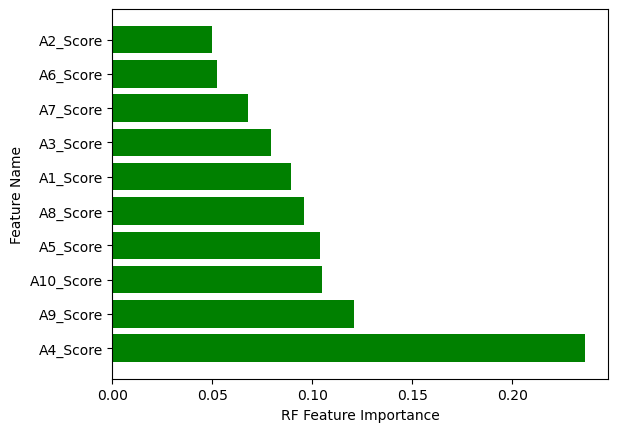

In [28]:
#do freature ranking
index_10Q = np.argsort(model_10Q.feature_importances_).tolist()

plt.barh(X_train_10Q.columns[index_10Q], model_10Q.feature_importances_[index_10Q], color=['green'])
plt.gca().invert_yaxis()
plt.xlabel("RF Feature Importance")
plt.ylabel("Feature Name")

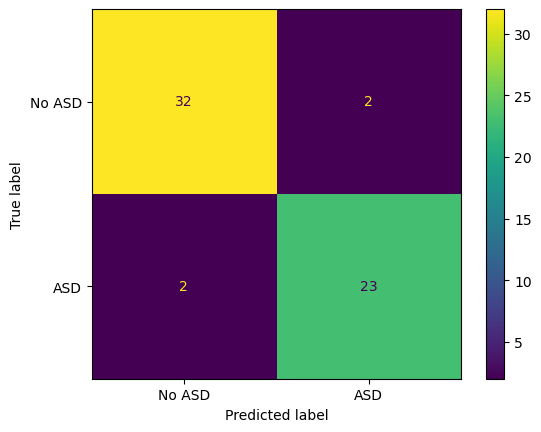

In [29]:
#plot confusion matrix
cm_10Q = confusion_matrix(y_test, y_pred_10Q)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_10Q, display_labels = ['No ASD', 'ASD'])
disp.plot()
plt.show()

## 3. Use features unrelated to AQ 10

In [30]:
#only keep the 6 features unrelated to the AQ 10 questionaire
X_train_unrelated = X_train[['age','gender','jundice','relation','austim','used_app_before']]
X_test_unrelated = X_test[['age','gender','jundice','relation','austim','used_app_before']]

model_unrelated = RandomForestClassifier(n_estimators = 500)
model_unrelated.fit(X_train_unrelated,y_train)

y_pred_unrelated = model_unrelated.predict(X_test_unrelated)

print("Used features:", X_train_unrelated.columns.tolist())
print("Accuracy:", accuracy_score(y_test, y_pred_unrelated))

Used features: ['age', 'gender', 'jundice', 'relation', 'austim', 'used_app_before']
Accuracy: 0.5084745762711864


Text(0, 0.5, 'Feature Name')

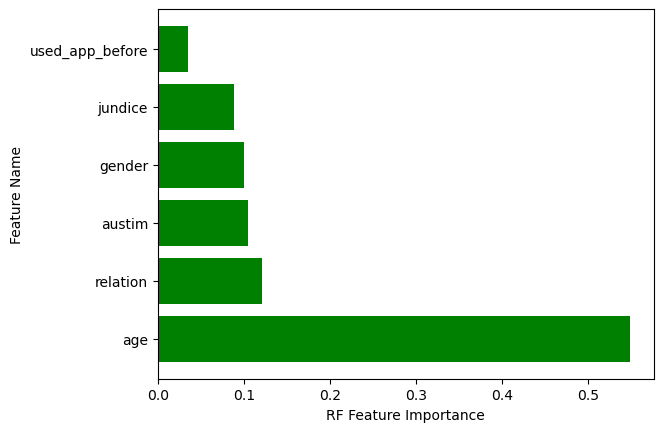

In [31]:
#do freature ranking
index_unrelated = np.argsort(model_unrelated.feature_importances_).tolist()

plt.barh(X_train_unrelated.columns[index_unrelated], model_unrelated.feature_importances_[index_unrelated], color=['green'])
plt.gca().invert_yaxis()
plt.xlabel("RF Feature Importance")
plt.ylabel("Feature Name")

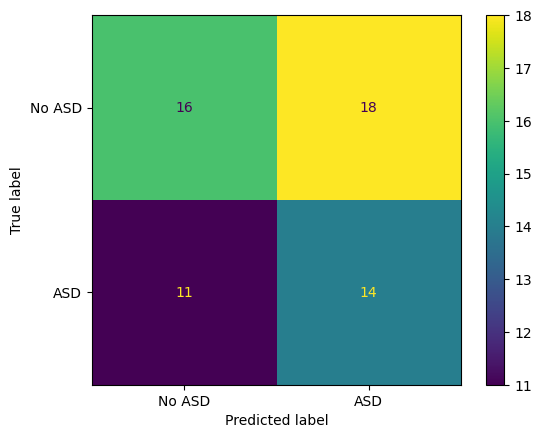

In [32]:
#plot confusion matrix
cm_unrelated = confusion_matrix(y_test, y_pred_unrelated)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_unrelated, display_labels = ['No ASD', 'ASD'])
disp.plot()
plt.show()

In [33]:
#explain the accuracy of this model
from scipy import stats
k = np.count_nonzero(y_test==y_pred_unrelated)
n = len(y_pred_unrelated)
print("Null hypothsis: The model trained on features unrelated to AQ10 is only guessing the result.")
print("Altenative hypothsis: The modle is not only guessing the result")
print("If the model is only guessing, for each result, it has 50% chance to get the correct answer.")
print("The nuber of correct answer follows a binomial distribution B(21,0.5)")
p = stats.binomtest(k,n,1/2).pvalue
print("The model achieved an accuracy of {:.1f}%.".format(sklearn.metrics.accuracy_score(y_test, y_pred_unrelated)*100))
print("P-Value of the result is {}.".format(p))
print("We can not reject the null hypothesis that the model is only guessing.")

Null hypothsis: The model trained on features unrelated to AQ10 is only guessing the result.
Altenative hypothsis: The modle is not only guessing the result
If the model is only guessing, for each result, it has 50% chance to get the correct answer.
The nuber of correct answer follows a binomial distribution B(21,0.5)
The model achieved an accuracy of 50.8%.
P-Value of the result is 1.0.
We can not reject the null hypothesis that the model is only guessing.
